In [1]:
import string
import itertools
import os
import subprocess
import random
import string
import re
import hashlib
import json

patternfile = "data/pattern.txt"
os.makedirs(os.path.dirname(patternfile), exist_ok=True)

class CustomRuntimeError(Exception):
    """Something failed in runtime"""
    def __init__(self,filename,message):
        self.filename = filename
        self.message = message
        

def randomString(stringLength=256, subject=True,num = 2):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    if subject:
        chunk = 1024*1024*128 # 128MB
        if os.path.exists("./data/subject.txt"):
          os.remove("./data/subject.txt")
        with open("./data/subject.txt","a+") as s:
            for j in range(0,int(((stringLength+chunk-1)/chunk))):
                    rightBound = (j+1)*chunk if (j+1) * chunk < stringLength else stringLength
                    randomStr = ''.join(random.choice(letters[:num]) for i in range(j*chunk,rightBound))
                    s.write(randomStr)
        return
    else:
        randomStr =  ''.join(random.choice(letters[:num]) for i in range(stringLength))
#         with open("./data/pattern.txt","w") as s:
#             s.write(randomStr)
        return randomStr

# output files with profile data
files = [
    
#         "r_naive_spec_chunk.txt",
#         "r_naive_spec_nochunk.txt",
#         "clean_pe_nochunk.txt",
        "mclean_pe_nochunk.txt",
#         "mclean_nope_nochunk.txt",
#         "clean_pe_chunk.txt",
#         "cuda_naive_chunk.txt",
#         "cuda_naive_nochunk.txt",
#         "cuda_naivec_nochunk.txt",
        "cuda_mnaive_nochunk.txt",
        "cuda_mnaivec_nochunk.txt",
        "cuda_mnaivesh_nochunk.txt",
        "cuda_mnaivetex_nochunk.txt",
#         "cuda_naivec_chunk.txt",
#         "cuda_naivesh_chunk.txt",
#         "cuda_naivesh_nochunk.txt",
#         "cuda_kmp_chunk.txt",
#         "cuda_kmpc_chunk.txt"
        
        
        ]
# path to nvprof
nvprof = "/usr/local/cuda-10.2/bin/nvprof"

def match(pattern,filename,size = 0, offset = 0, verbose=1):
    
#     commands to collect profile data: 2> to redirect nvprof stderr output
# Options:
# ("pattern","path to file with patterns to look for") if multiple patterns the delimiter should be \x00, 
#     single pattern size should be < cuda block_size(1024 by default) and length of patterns in total should be < 128*64 and
#     the number of patterns should be < 64
# ("filename","path to file with subject string)
# ("size", "size of data to be fectched from @filename in bytes")
# ("offset", "offset of data to be fetched from @filename read in bytes")
# ("algorithm","algorithm name to run pattern matching with")
# Available names for type=0:
#     mcleanpe --- for match_spec.out --- partially evaluated version
#     mnaive --- for match.out --- naive cuda implementation with patterns residing in global memory
#     mnaivec --- for match.out --- naive cuda implementation with patterbs residing in constant memory
#     mnaivesh --- for match.out --- naive cuda implementation with patterns residing in shared memory

# ("type","type of algorithm parallelization: 0 stands for nochunk-based(thread per subject string byte) and 1 for chunk-based(data-parallel)")
# ("v,verbose","print matching result or not to stdout: 0 stands for 'No' 1 for 'Yes'");
    commands = [

    f"{nvprof} --normalized-time-unit ms ./match_spec.out --pattern={pattern} --filename={filename} --algorithm=mcleanpe --type=1 --size={size} --offset={offset} --verbose={verbose} 2> mclean_pe_nochunk.txt",
    f"{nvprof} --normalized-time-unit ms ./match.out --pattern={pattern} --filename={filename} --algorithm=mnaivec --type=1 --size={size} --offset={offset} --verbose={verbose} 2> cuda_mnaivec_nochunk.txt",
    f"{nvprof} --normalized-time-unit ms ./match.out --pattern={pattern} --filename={filename} --algorithm=mnaive --type=1 --size={size} --offset={offset} --verbose={verbose} 2> cuda_mnaive_nochunk.txt",
    f"{nvprof} --normalized-time-unit ms ./match.out --pattern={pattern} --filename={filename} --algorithm=mnaivesh --type=1 --size={size} --offset={offset} --verbose={verbose} 2> cuda_mnaivesh_nochunk.txt",
    f"{nvprof} --normalized-time-unit ms ./match.out --pattern={pattern} --filename={filename} --algorithm=mnaivetex --type=1 --size={size} --offset={offset} --verbose={verbose} 2> cuda_mnaivetex_nochunk.txt",
        
    ]
    
    for command in commands:
        if(os.system(command) == 0):
            continue
        raise CustomRuntimeError(command,"")

                
def generate_strings(length=3):
#     chars = string.ascii_letters + string.digits  # "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    chars = 'ab'
    for item in itertools.product(chars, repeat=length):
        yield "".join(item)
       
# cartesian product of input iterables
# strings = [''.join(x) for x in itertools.product('abcdefghijklmnopqrstuvwxyz', repeat=20)]
# patterns = [''.join(x) for x in itertools.product('abcdefghijklmnopqrstuvwxyz', repeat=6)]



def all_equal(iterable):
    "Returns True if all the elements are equal to each other"
    g = itertools.groupby(iterable)
    return next(g, True) and not next(g, False)

# def test():
#     """need to change regex to check"""
#     rePatt = re.compile('running time [\d]*\.?[\d]*')
#     eq = True
#     ofiles = [open(file,'r') for file in files]
#     outputs = ["" for f in ofiles]
#     mask = [False for i in ofiles]
#     def innerLoop1(f):
#         while(rePatt.findall(f.readline()) == []):
#             pass
        
#     for f in ofiles:
#             innerLoop1(f)
#     def innerLoop2():
#         while(True):
#             for i in range(len(ofiles)):
#                 if(mask[i] == False):
#                     c = ofiles[i].read(1)
#                     if(c == '1' or c == '0'):
#                         outputs[i] = c
#                         mask[i] = True
#                     if all(mask):
#                         return
#                     if c == '':
#                         return
#     innerLoop2()                
#     eq = eq and (all_equal(outputs))
#     while eq and all(map(lambda x : x != '',outputs)):
#         for i in range(len(ofiles)):
#             l = ofiles[i].read(16*1024*1024)
#             outputs[i] = l
#         eq = eq and (all_equal(outputs))
    
#     for f in ofiles:
#         f.close()
        
#     return eq
            
def compile_time():
    rePatt = re.compile('compilation time [\d]*\.?[\d]*')
    result = []
    for file in cfiles:
        with open(file) as f:
            for line in f:
                if(rePatt.findall(line) != []):
                    result.append(line)
                    break
    timePatt = re.compile('[\d]+\.?[\d]*')
    clocks = []
    for r in result:
        clocks.append(timePatt.findall(r)[0])
    
    return clocks

# def time():
#     rePatt = re.compile('running time [\d]*\.?[\d]*')
#     result = []
#     for file in files:
#         success = False
#         with open(file) as mN:
#             for line in mN:
#                 if (rePatt.findall(line) != []):
#                     result.append(line)
#                     success = True
#                     break
#         if(not success):
#             with open(file) as f:
#                 raise CustomRuntimeError(file,f.readlines())
#     return(result)
    
# rePatt = re.compile('[\d]+\.?[\d]*')
# for line in time():
#     print(rePatt.findall(line))

# to capture time from nvprof output
def time():
    rePatt = re.compile('lambda_\w*|match_\w*')
    result = []
    for file in files:
        success = False
        with open(file,"rb") as mN:
            for line in mN.readlines()[4:]:
                ld = line.decode('utf-8')
                if (rePatt.findall(ld) != []):
                    result.append(ld)
                    success = True
                    break
        if(not success):
            with open(file) as f:
                raise CustomRuntimeError(file,f.readlines())
    return(result)
    
# rePatt = re.compile('[\d]+\.?[\d]*')
rePatt = re.compile('[-+]?[0-9]*\.?[0-9]+[eE]?[-+]?[0-9]+')


#size, offset in MB
def checkTimeStatic(size,filename,patterns,offset=0,verbose=1,silent = False,compileTime = False):
    res = []
    for p in patterns:
        with open(patternfile, 'wb') as fb:
                 fb.write(p)
        match(patternfile,filename,size * 1024 * 1024, offset * 1024 * 1024,verbose) #prerun for ji
        clocks = []
        for line in time():
            if(not silent):
                clocks.append(rePatt.findall(line))
        entry = [x[1] for x in clocks] # x[1] is time
        res.append(entry)
        if(compileTime):
            print("Compilation time")
            print(compile_time())
#         else:
#             print("Match failed " + pattern)
#             return
    return res




# test = [[(['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['45', '41', '36', '34', '34', '28', '6', '0', '1', '4', '0', '0']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['59', '45', '44', '35', '34', '35', '6', '0', '1', '3', '0', '0']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['45', '35', '42', '32', '30', '6', '0', '1', '5', '0', '0']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['56', '54', '35', '36', '31', '28', '6', '0', '1', '4', '0', '0']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['46', '38', '36', '36', '31', '29', '6', '0', '1', '3', '0', '0']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['42', '35', '35', '35', '31', '28', '6', '0', '1', '3', '0', '0']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['62', '35', '35', '30', '29', '6', '0', '1', '4', '0', '0']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['57', '36', '35', '31', '28', '6', '0', '1', '4', '0', '0']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['55', '38', '36', '36', '30', '28', '6', '0', '1', '3', '0', '0']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['56', '39', '35', '36', '31', '29', '6', '0', '1', '4', '0', '0'])], [(['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['45', '38', '36', '35', '31', '29', '26', '4', '20', '20', '2', '3']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['48', '37', '36', '36', '31', '29', '26', '4', '18', '17', '2', '3']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['44', '37', '35', '31', '29', '26', '4', '17', '27', '2', '3']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['49', '43', '35', '35', '31', '29', '27', '4', '19', '20', '2', '3']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['46', '37', '36', '36', '31', '29', '26', '4', '18', '16', '2', '3']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['41', '36', '35', '35', '31', '29', '26', '4', '20', '18', '2', '3']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['61', '36', '35', '31', '29', '26', '4', '18', '20', '2', '3']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['58', '36', '36', '31', '28', '26', '4', '18', '24', '2', '3']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['55', '38', '35', '36', '31', '29', '26', '4', '18', '15', '2', '3']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['57', '40', '36', '36', '31', '29', '26', '4', '19', '19', '2', '3'])], [(['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['47', '39', '36', '35', '31', '28', '51', '8', '39', '41', '5', '7']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['47', '37', '35', '35', '31', '28', '51', '8', '37', '34', '5', '7']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['45', '36', '36', '31', '28', '52', '8', '35', '55', '5', '7']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['49', '38', '36', '35', '30', '28', '51', '8', '38', '41', '5', '7']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['46', '37', '36', '35', '31', '28', '51', '8', '37', '32', '5', '7']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['42', '37', '36', '35', '31', '28', '51', '8', '39', '36', '5', '7']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['61', '46', '35', '32', '29', '52', '8', '37', '40', '5', '7']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['56', '36', '35', '30', '28', '51', '8', '36', '49', '5', '7']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['53', '38', '35', '35', '31', '29', '51', '8', '37', '31', '5', '7']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['56', '39', '36', '35', '31', '28', '51', '8', '38', '39', '5', '7'])], [(['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['49', '38', '36', '36', '31', '28', '127', '20', '99', '102', '14', '17']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['47', '38', '35', '36', '31', '28', '127', '20', '93', '85', '14', '17']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['44', '35', '35', '30', '28', '128', '20', '90', '138', '14', '17']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['53', '39', '60', '44', '31', '29', '127', '20', '99', '102', '14', '17']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['46', '37', '36', '36', '31', '29', '126', '20', '95', '81', '14', '17']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['43', '36', '35', '36', '31', '28', '128', '20', '102', '89', '14', '17']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['61', '35', '36', '31', '29', '127', '20', '96', '101', '14', '17']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['57', '36', '36', '45', '37', '126', '20', '93', '122', '14', '17']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['53', '38', '38', '37', '31', '28', '126', '20', '96', '78', '14', '17']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['55', '50', '39', '47', '39', '29', '128', '20', '99', '99', '14', '17'])], [(['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['49', '39', '37', '35', '30', '28', '251', '40', '203', '205', '29', '35']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['50', '39', '37', '36', '31', '29', '253', '40', '191', '171', '29', '35']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['45', '36', '35', '31', '29', '252', '40', '185', '276', '29', '35']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['70', '44', '42', '41', '35', '30', '252', '40', '201', '205', '29', '35']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['50', '37', '36', '37', '34', '29', '253', '40', '190', '163', '29', '35']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['43', '36', '35', '37', '31', '29', '252', '40', '205', '179', '29', '35']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['61', '36', '35', '33', '34', '252', '40', '195', '203', '29', '35']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['57', '38', '37', '33', '29', '248', '40', '191', '245', '29', '35']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['55', '43', '39', '36', '32', '31', '254', '40', '195', '157', '29', '35']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['60', '41', '53', '37', '32', '30', '251', '40', '200', '198', '29', '35'])], [(['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['46', '38', '37', '37', '31', '29', '377', '61', '304', '308', '44', '53']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['49', '37', '36', '36', '31', '29', '376', '61', '280', '257', '44', '53']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['45', '36', '35', '31', '29', '374', '61', '279', '414', '44', '53']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['51', '39', '36', '36', '31', '29', '378', '61', '306', '308', '44', '53']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['47', '37', '36', '35', '32', '29', '377', '61', '289', '245', '44', '53']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['43', '36', '37', '36', '31', '29', '374', '61', '307', '269', '44', '53']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['61', '36', '36', '31', '29', '382', '61', '297', '305', '44', '53']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['57', '36', '36', '31', '29', '378', '61', '288', '367', '44', '53']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['56', '39', '36', '36', '31', '29', '375', '61', '294', '235', '44', '53']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['56', '40', '36', '36', '32', '30', '384', '61', '300', '297', '44', '53'])], [(['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['48', '39', '36', '35', '31', '29', '503', '81', '403', '410', '58', '70']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['47', '38', '36', '36', '32', '29', '504', '81', '378', '343', '58', '70']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['45', '35', '35', '38', '29', '509', '81', '370', '552', '58', '70']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['66', '39', '36', '36', '31', '30', '497', '81', '403', '410', '58', '70']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['47', '41', '41', '36', '35', '32', '503', '81', '381', '326', '58', '70']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['45', '36', '37', '38', '32', '30', '507', '81', '408', '360', '58', '70']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['62', '36', '36', '31', '30', '510', '81', '386', '407', '58', '70']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['57', '36', '36', '31', '29', '499', '81', '383', '489', '58', '71']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['57', '38', '36', '35', '33', '29', '510', '81', '392', '313', '58', '70']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['60', '39', '37', '36', '31', '29', '504', '81', '397', '397', '58', '70'])], [(['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['49', '39', '36', '37', '33', '33', '749', '121', '606', '615', '88', '106']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['50', '41', '37', '37', '31', '30', '754', '121', '571', '515', '88', '106']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['46', '36', '36', '43', '29', '753', '121', '554', '829', '88', '106']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['49', '39', '36', '36', '31', '30', '755', '121', '607', '616', '88', '106']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['47', '37', '37', '36', '31', '30', '765', '122', '574', '490', '88', '106']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['43', '38', '50', '36', '46', '29', '754', '122', '615', '540', '88', '106']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['61', '37', '35', '34', '30', '755', '121', '584', '611', '88', '106']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['58', '37', '41', '34', '29', '753', '122', '577', '734', '88', '106']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['55', '39', '36', '36', '34', '31', '756', '121', '587', '470', '88', '106']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['60', '40', '37', '36', '32', '29', '763', '122', '599', '595', '88', '106'])], [(['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['49', '39', '36', '36', '32', '29', '1003', '162', '803', '821', '117', '142']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['48', '37', '36', '44', '31', '29', '1005', '162', '758', '687', '117', '142']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['45', '36', '36', '31', '29', '998', '162', '738', '1105', '117', '141']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['50', '38', '35', '35', '31', '28', '1004', '162', '805', '822', '117', '142']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['49', '38', '38', '36', '31', '28', '1005', '162', '767', '653', '117', '142']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['44', '36', '35', '35', '32', '29', '1007', '162', '811', '720', '117', '142']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['61', '35', '37', '57', '43', '1004', '162', '777', '814', '117', '142']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['63', '39', '40', '35', '30', '1000', '162', '765', '979', '117', '141']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['61', '59', '37', '62', '53', '53', '999', '163', '772', '627', '117', '141']), (['aaababbbbbbb', 'baaabbababba', 'bbbbbaaabbba', 'bbbaaabbabbb', 'baaaabbabbab', 'aababababbaa', 'aabaaabababa', 'bbbbaababbab', 'abbbbbbabbab', 'ababbbbabaab'], ['67', '41', '38', '37', '33', '33', '1010', '162', '796', '794', '117', '142'])]]

# test_data = [[['59', '40', '40', '49', '45', '38', '35', '38', '31', '41', '6', '0', '0', '0'], ['124', '60', '65', '58', '36', '51', '38', '32', '35', '52', '6', '0', '0', '0'], ['49', '45', '67', '67', '50', '45', '46', '65', '47', '75', '6', '0', '0', '0'], ['58', '44', '56', '55', '64', '77', '50', '64', '51', '48', '6', '0', '0', '0'], ['70', '67', '86', '59', '64', '58', '50', '45', '60', '56', '6', '0', '0', '0'], ['98', '66', '92', '99', '67', '71', '63', '66', '46', '59', '6', '0', '0', '0'], ['83', '52', '56', '88', '48', '46', '40', '36', '46', '57', '6', '0', '0', '0']], [['60', '47', '47', '57', '46', '42', '35', '36', '39', '41', '51', '8', '5', '7'], ['59', '48', '46', '62', '48', '49', '38', '35', '39', '47', '51', '8', '5', '7'], ['60', '49', '47', '62', '43', '42', '37', '35', '34', '38', '51', '8', '5', '7'], ['57', '43', '46', '56', '44', '42', '45', '41', '52', '58', '51', '8', '5', '7'], ['63', '56', '55', '70', '61', '59', '48', '51', '48', '52', '51', '8', '5', '7'], ['95', '64', '59', '86', '56', '55', '51', '47', '46', '50', '51', '8', '5', '7'], ['96', '61', '66', '94', '55', '56', '50', '46', '47', '52', '52', '8', '5', '7']], [['86', '64', '62', '70', '56', '54', '56', '54', '79', '51', '128', '20', '14', '17'], ['71', '53', '63', '72', '55', '52', '48', '45', '41', '50', '126', '20', '14', '17'], ['89', '69', '51', '79', '53', '51', '48', '44', '32', '81', '126', '20', '14', '17'], ['45', '36', '37', '45', '35', '35', '30', '28', '29', '32', '128', '20', '14', '17'], ['41', '35', '35', '41', '35', '35', '31', '28', '29', '32', '128', '20', '14', '17'], ['53', '37', '37', '53', '36', '35', '30', '28', '29', '33', '126', '20', '14', '17'], ['55', '38', '38', '55', '35', '35', '33', '28', '28', '32', '127', '20', '14', '17']], [['50', '38', '38', '45', '35', '35', '30', '28', '29', '32', '249', '40', '29', '35'], ['47', '38', '37', '46', '36', '35', '30', '28', '37', '32', '254', '40', '29', '35'], ['49', '38', '38', '49', '35', '35', '30', '28', '29', '32', '253', '40', '29', '35'], ['57', '38', '40', '50', '36', '35', '31', '28', '29', '32', '251', '40', '29', '35'], ['42', '36', '36', '42', '35', '35', '30', '28', '29', '32', '251', '40', '29', '35'], ['54', '38', '38', '54', '35', '35', '30', '28', '29', '33', '254', '40', '29', '35'], ['56', '39', '39', '56', '35', '35', '30', '28', '29', '33', '251', '40', '29', '35']], [['49', '38', '38', '45', '35', '35', '30', '28', '29', '33', '380', '61', '44', '53'], ['47', '37', '37', '47', '35', '35', '31', '28', '30', '32', '378', '61', '44', '53'], ['50', '38', '38', '50', '35', '35', '30', '29', '29', '32', '380', '60', '44', '53'], ['46', '37', '37', '46', '35', '35', '31', '28', '29', '33', '371', '61', '44', '53'], ['42', '35', '36', '42', '37', '36', '30', '28', '29', '32', '376', '61', '44', '53'], ['54', '38', '38', '55', '36', '36', '30', '29', '29', '32', '377', '61', '44', '53'], ['56', '38', '39', '56', '35', '35', '31', '28', '29', '33', '379', '60', '44', '53']], [['45', '38', '39', '45', '36', '35', '31', '28', '29', '34', '500', '81', '58', '70'], ['47', '37', '37', '47', '35', '35', '30', '28', '29', '33', '505', '81', '58', '70'], ['49', '38', '38', '50', '35', '35', '31', '29', '29', '33', '496', '81', '58', '70'], ['46', '37', '37', '60', '35', '35', '31', '29', '29', '32', '502', '81', '58', '70'], ['42', '36', '36', '42', '35', '35', '31', '29', '30', '32', '505', '81', '58', '70'], ['54', '38', '38', '55', '36', '35', '31', '28', '29', '32', '501', '81', '58', '70'], ['56', '39', '40', '56', '36', '36', '31', '29', '29', '33', '507', '81', '58', '71']], [['45', '39', '38', '45', '35', '35', '31', '28', '29', '33', '753', '122', '88', '106'], ['47', '37', '37', '47', '35', '35', '31', '29', '29', '33', '753', '122', '88', '106'], ['49', '38', '38', '49', '35', '36', '31', '29', '30', '33', '751', '122', '88', '106'], ['46', '37', '37', '46', '36', '35', '31', '28', '31', '33', '755', '122', '88', '106'], ['43', '36', '36', '42', '36', '36', '31', '29', '29', '33', '745', '122', '88', '106'], ['54', '38', '38', '54', '36', '36', '31', '28', '29', '33', '757', '122', '87', '106'], ['56', '39', '39', '57', '35', '35', '31', '29', '30', '33', '751', '122', '87', '106']], [['51', '39', '38', '46', '36', '36', '31', '29', '29', '33', '1001', '162', '117', '141'], ['47', '37', '38', '47', '36', '35', '31', '29', '29', '32', '1003', '163', '117', '141'], ['49', '38', '38', '50', '36', '36', '31', '28', '30', '33', '992', '163', '117', '142'], ['46', '37', '38', '47', '36', '36', '31', '29', '31', '33', '1000', '162', '117', '141'], ['42', '36', '36', '42', '35', '36', '30', '29', '29', '33', '1013', '162', '117', '141'], ['55', '38', '38', '54', '35', '37', '31', '29', '29', '33', '1006', '162', '117', '142'], ['56', '39', '39', '56', '35', '35', '31', '29', '30', '33', '1015', '162', '117', '141']], [['50', '38', '39', '45', '36', '36', '31', '29', '29', '33', '2001', '325', '234', '283'], ['47', '37', '37', '47', '36', '35', '31', '29', '29', '33', '2005', '325', '234', '283'], ['49', '39', '38', '49', '35', '36', '31', '29', '29', '33', '2005', '325', '234', '283'], ['46', '37', '37', '47', '35', '36', '31', '29', '30', '33', '2009', '325', '234', '283'], ['43', '37', '36', '42', '35', '36', '31', '29', '29', '32', '1995', '325', '234', '283'], ['55', '38', '39', '55', '36', '36', '31', '29', '29', '33', '2002', '325', '234', '283'], ['56', '39', '39', '57', '36', '36', '31', '29', '30', '33', '2009', '325', '234', '283']], [['48', '38', '38', '45', '35', '35', '31', '28', '29', '32', '3011', '487', '351', '424'], ['47', '37', '37', '47', '35', '35', '31', '28', '29', '33', '3016', '487', '351', '424'], ['49', '38', '38', '49', '36', '35', '31', '29', '29', '32', '3001', '487', '351', '424'], ['46', '45', '37', '46', '35', '35', '31', '28', '29', '32', '3003', '487', '351', '424'], ['42', '36', '36', '42', '35', '35', '31', '29', '29', '32', '3010', '487', '351', '424'], ['54', '38', '38', '54', '35', '36', '31', '29', '30', '33', '3010', '487', '351', '424'], ['56', '39', '39', '56', '35', '35', '31', '28', '29', '33', '3015', '487', '351', '424']], [['47', '40', '38', '46', '37', '35', '30', '29', '30', '32', '3996', '649', '468', '566'], ['66', '37', '39', '49', '37', '35', '30', '29', '29', '33', '4000', '649', '468', '566'], ['49', '40', '38', '49', '36', '36', '31', '29', '29', '33', '3996', '649', '468', '566'], ['46', '38', '39', '46', '35', '36', '30', '28', '29', '32', '3999', '649', '468', '566'], ['42', '36', '36', '42', '36', '35', '31', '29', '29', '34', '4003', '649', '468', '566'], ['54', '38', '39', '54', '36', '36', '31', '29', '29', '32', '4016', '649', '468', '566'], ['56', '39', '39', '56', '37', '35', '31', '28', '30', '36', '4010', '649', '468', '566']], [['48', '39', '39', '45', '35', '35', '31', '29', '29', '33', '5011', '815', '588', '711'], ['47', '37', '38', '47', '35', '36', '31', '28', '29', '33', '5031', '815', '588', '711'], ['49', '38', '38', '50', '35', '35', '32', '29', '29', '32', '5025', '815', '588', '711'], ['46', '37', '37', '46', '35', '35', '31', '28', '30', '33', '4990', '815', '588', '711'], ['42', '36', '36', '42', '35', '35', '31', '29', '29', '32', '5024', '815', '588', '711'], ['55', '38', '38', '55', '35', '35', '31', '28', '29', '33', '5035', '815', '588', '711'], ['56', '39', '39', '56', '35', '35', '31', '29', '29', '33', '5024', '815', '588', '711']], [['48', '39', '38', '46', '35', '35', '31', '28', '30', '33', '5995', '975', '704', '851'], ['47', '37', '37', '47', '35', '36', '31', '29', '30', '34', '6005', '975', '704', '851'], ['49', '38', '38', '51', '35', '35', '31', '29', '30', '33', '6009', '976', '704', '851'], ['46', '37', '37', '46', '36', '35', '31', '29', '29', '33', '6000', '975', '704', '851'], ['42', '36', '36', '43', '35', '35', '31', '29', '29', '33', '5980', '975', '704', '851'], ['54', '38', '39', '54', '35', '35', '31', '28', '29', '33', '6020', '975', '704', '851'], ['100', '39', '39', '57', '54', '37', '31', '29', '44', '33', '6012', '975', '704', '851']], [['48', '39', '39', '48', '37', '35', '31', '80', '38', '34', '7994', '1296', '934', '1129'], ['84', '69', '63', '107', '47', '43', '36', '33', '36', '63', '8019', '1296', '934', '1129'], ['61', '48', '41', '52', '36', '55', '39', '53', '43', '36', '8049', '1296', '934', '1129'], ['69', '58', '55', '78', '86', '36', '31', '46', '48', '33', '8032', '1296', '934', '1129'], ['62', '36', '37', '61', '37', '50', '44', '47', '41', '33', '8018', '1296', '934', '1129'], ['55', '39', '40', '55', '36', '36', '31', '29', '30', '33', '8020', '1296', '934', '1129'], ['57', '41', '39', '57', '54', '36', '32', '29', '46', '45', '8006', '1296', '934', '1129']], [['48', '59', '57', '63', '48', '50', '51', '41', '74', '46', '9271', '1505', '1086', '1312'], ['75', '67', '55', '66', '56', '45', '81', '39', '49', '46', '9289', '1504', '1085', '1312'], ['70', '61', '59', '70', '44', '46', '43', '49', '148', '45', '9269', '1505', '1087', '1313'], ['71', '62', '69', '82', '65', '112', '49', '72', '76', '86', '9268', '1504', '1085', '1311'], ['71', '84', '37', '66', '72', '54', '50', '54', '54', '67', '9266', '1504', '1085', '1311'], ['72', '89', '111', '82', '52', '68', '74', '41', '42', '98', '9246', '1504', '1085', '1311'], ['97', '55', '63', '73', '47', '92', '43', '50', '50', '68', '9239', '1505', '1085', '1311']]]

testData = [[['50', '65', '35', '32', '99', '111', '32', '34', '2', '0', '0', '0'], ['54', '52', '44', '32', '117', '98', '32', '33', '2', '0', '0', '0'], ['75', '54', '35', '36', '100', '101', '31', '33', '2', '0', '0', '0'], ['53', '51', '35', '36', '171', '105', '32', '35', '2', '0', '0', '0'], ['48', '53', '39', '31', '104', '103', '32', '33', '2', '0', '0', '0'], ['63', '54', '34', '37', '112', '113', '32', '45', '2', '0', '0', '0'], ['62', '51', '43', '31', '102', '106', '31', '33', '2', '0', '0', '0']], [['84', '140', '111', '49', '143', '108', '42', '76', '40', '8', '8', '9'], ['85', '152', '87', '41', '116', '120', '60', '78', '40', '8', '8', '9'], ['79', '140', '76', '39', '115', '101', '49', '77', '40', '8', '8', '9'], ['77', '159', '74', '57', '130', '169', '51', '81', '40', '8', '8', '9'], ['78', '205', '137', '74', '227', '189', '45', '83', '40', '8', '8', '9'], ['93', '171', '82', '48', '115', '105', '55', '87', '41', '8', '8', '9'], ['157', '169', '92', '55', '167', '231', '51', '101', '40', '8', '8', '9']], [['92', '278', '155', '113', '241', '128', '70', '160', '104', '20', '20', '22'], ['126', '328', '171', '61', '227', '145', '64', '151', '104', '21', '20', '23'], ['130', '301', '163', '68', '207', '145', '65', '155', '104', '20', '20', '22'], ['131', '351', '155', '67', '217', '206', '105', '149', '104', '21', '20', '22'], ['150', '439', '205', '85', '202', '113', '78', '141', '104', '20', '23', '23'], ['197', '391', '199', '92', '266', '243', '83', '173', '104', '21', '20', '22'], ['182', '303', '169', '62', '216', '109', '53', '138', '104', '20', '20', '22']], [['135', '493', '239', '67', '298', '112', '105', '237', '204', '41', '40', '45'], ['188', '606', '246', '68', '281', '147', '78', '242', '210', '42', '40', '45'], ['135', '530', '259', '70', '284', '152', '71', '238', '211', '41', '40', '45'], ['157', '604', '242', '84', '282', '111', '98', '241', '208', '42', '40', '45'], ['268', '666', '231', '70', '312', '144', '71', '241', '201', '41', '40', '45'], ['162', '640', '249', '81', '274', '125', '75', '264', '207', '42', '40', '45'], ['146', '553', '244', '72', '297', '126', '77', '245', '209', '41', '40', '45']], [['178', '722', '347', '88', '405', '133', '93', '341', '315', '62', '61', '68'], ['195', '878', '341', '88', '380', '133', '93', '349', '303', '63', '61', '68'], ['179', '758', '346', '88', '378', '133', '92', '332', '310', '62', '61', '68'], ['197', '888', '346', '88', '386', '133', '93', '346', '307', '63', '61', '68'], ['185', '981', '337', '88', '381', '134', '92', '344', '306', '62', '61', '68'], ['208', '918', '341', '88', '372', '134', '94', '337', '310', '63', '61', '68'], ['189', '696', '344', '87', '388', '134', '92', '345', '317', '62', '61', '68']], [['216', '950', '423', '107', '457', '162', '113', '435', '402', '83', '81', '90'], ['245', '1128', '432', '107', '487', '158', '113', '428', '407', '84', '81', '91'], ['220', '997', '452', '106', '481', '186', '113', '441', '408', '83', '81', '91'], ['247', '1168', '449', '107', '488', '167', '114', '452', '420', '84', '81', '91'], ['232', '1297', '445', '107', '491', '154', '113', '445', '399', '83', '81', '91'], ['258', '1211', '434', '107', '461', '154', '113', '427', '385', '84', '81', '91'], ['233', '914', '436', '107', '482', '155', '113', '436', '413', '83', '81', '91']], [['301', '1404', '646', '146', '663', '199', '155', '647', '599', '125', '121', '136'], ['341', '1667', '621', '146', '699', '209', '156', '632', '575', '126', '122', '137'], ['305', '1477', '645', '146', '700', '198', '155', '639', '631', '125', '121', '136'], ['346', '1734', '645', '146', '706', '198', '156', '649', '634', '126', '122', '137'], ['326', '1925', '613', '146', '693', '198', '155', '632', '580', '125', '122', '136'], ['359', '1795', '650', '147', '692', '197', '156', '652', '621', '126', '123', '137'], ['321', '1351', '661', '147', '701', '197', '155', '646', '625', '125', '122', '136']], [['385', '1859', '828', '185', '865', '241', '197', '833', '772', '167', '162', '182'], ['439', '2211', '859', '185', '888', '241', '198', '832', '841', '168', '163', '183'], ['388', '1956', '839', '185', '883', '239', '197', '859', '790', '167', '162', '182'], ['445', '2299', '830', '186', '879', '242', '198', '814', '824', '168', '163', '183'], ['419', '2555', '857', '185', '876', '239', '198', '857', '824', '167', '162', '182'], ['460', '2382', '828', '185', '907', '240', '198', '848', '809', '168', '163', '183'], ['405', '1788', '848', '185', '885', '240', '197', '850', '798', '167', '163', '182']], [['716', '3678', '1634', '340', '1662', '412', '363', '1576', '1570', '334', '324', '363'], ['831', '4384', '1673', '341', '1722', '410', '365', '1692', '1584', '336', '326', '366'], ['726', '3871', '1667', '339', '1666', '408', '363', '1697', '1577', '334', '325', '364'], ['845', '4558', '1599', '342', '1746', '410', '366', '1621', '1506', '336', '327', '366'], ['795', '5070', '1617', '339', '1650', '406', '365', '1621', '1633', '334', '325', '364'], ['864', '4726', '1610', '341', '1691', '407', '366', '1682', '1632', '336', '327', '366'], ['752', '3535', '1543', '340', '1695', '406', '364', '1630', '1578', '335', '325', '365']], [['1050', '5498', '2440', '494', '2372', '575', '530', '2337', '2339', '500', '486', '545'], ['1222', '6558', '2503', '498', '2550', '575', '533', '2514', '2447', '504', '489', '549'], ['1062', '5788', '2309', '494', '2443', '573', '531', '2387', '2308', '501', '487', '546'], ['1241', '6820', '2482', '498', '2541', '575', '533', '2518', '2478', '504', '490', '549'], ['1171', '7586', '2386', '495', '2387', '574', '531', '2441', '2383', '502', '487', '546'], ['1265', '7066', '2216', '498', '2433', '576', '534', '2247', '2362', '504', '490', '550'], ['1098', '5282', '2455', '495', '2472', '574', '531', '2466', '2362', '502', '488', '547']], [['1383', '7320', '3234', '648', '3317', '740', '697', '3240', '3208', '667', '649', '727'], ['1612', '8731', '3063', '653', '3228', '743', '702', '3182', '3189', '672', '653', '732'], ['1397', '7704', '3263', '649', '3187', '740', '697', '3167', '3190', '668', '649', '728'], ['1638', '9082', '3177', '655', '3243', '744', '702', '3215', '3263', '673', '654', '733'], ['1546', '10105', '3077', '652', '3298', '742', '698', '3240', '3195', '669', '650', '729'], ['1670', '9408', '3193', '654', '3330', '745', '702', '3243', '3158', '673', '654', '733'], ['1442', '7030', '3237', '651', '3320', '743', '699', '3231', '3155', '670', '651', '730']], [['1712', '9134', '3873', '804', '3969', '911', '867', '3855', '3786', '837', '814', '911'], ['2000', '10902', '3504', '810', '3990', '915', '872', '3893', '3925', '842', '819', '917'], ['1734', '9618', '3664', '805', '3990', '910', '868', '3982', '4088', '838', '814', '912'], ['2037', '11342', '3737', '810', '4026', '918', '874', '3919', '3751', '843', '820', '918'], ['1922', '12620', '3709', '807', '3924', '912', '869', '3944', '3743', '839', '815', '913'], ['2071', '11752', '3981', '811', '4007', '917', '874', '3810', '3745', '844', '820', '919'], ['1791', '8804', '3903', '807', '4129', '915', '870', '3881', '3801', '840', '816', '915']], [['2044', '10962', '4538', '961', '4891', '1105', '1033', '4677', '4743', '1003', '975', '1092'], ['2393', '13078', '4762', '967', '4833', '1085', '1039', '4856', '4790', '1009', '981', '1099'], ['2072', '11554', '4673', '961', '4811', '1081', '1054', '4823', '4753', '1004', '975', '1093'], ['2443', '13602', '4524', '968', '4750', '1087', '1041', '4767', '4518', '1010', '982', '1100'], ['2320', '15164', '4671', '963', '4888', '1083', '1035', '4811', '4600', '1005', '977', '1094'], ['2497', '14097', '4632', '968', '4726', '1085', '1041', '4761', '4648', '1011', '982', '1101'], ['2157', '10525', '4666', '975', '4782', '1094', '1037', '4810', '4684', '1006', '978', '1096']], [['2732', '14600', '5632', '1277', '6366', '1408', '1374', '6320', '6134', '1331', '1293', '1450'], ['3198', '17445', '5920', '1293', '6446', '1416', '1382', '6456', '6108', '1340', '1302', '1459'], ['2755', '15409', '6014', '1288', '6404', '1411', '1376', '6324', '6192', '1332', '1295', '1451'], ['3248', '18131', '6396', '1303', '6361', '1418', '1384', '6451', '6270', '1341', '1303', '1461'], ['3063', '20181', '6125', '1276', '6423', '1417', '1379', '6262', '6318', '1334', '1297', '1453'], ['3302', '18786', '6069', '1303', '6298', '1418', '1385', '6380', '5994', '1342', '1304', '1462'], ['2844', '14023', '6261', '1291', '6305', '1411', '1379', '6349', '6263', '1336', '1298', '1455']]]

testDataKmp = [[['51', '90', '141', '2', '1'], ['55', '98', '142', '2', '1'], ['55', '89', '213', '2', '1'], ['54', '85', '140', '2', '1'], ['50', '85', '139', '2', '1'], ['59', '83', '143', '2', '1'], ['62', '95', '152', '2', '1']], [['72', '295', '141', '40', '38'], ['71', '316', '138', '40', '36'], ['68', '305', '203', '40', '39'], ['141', '324', '224', '40', '36'], ['84', '331', '198', '40', '39'], ['109', '304', '197', '40', '38'], ['109', '324', '198', '40', '38']], [['113', '665', '229', '103', '100'], ['116', '641', '230', '104', '95'], ['109', '662', '227', '103', '99'], ['117', '638', '227', '104', '95'], ['113', '675', '218', '104', '102'], ['127', '624', '219', '104', '97'], ['117', '657', '232', '103', '99']], [['160', '1237', '298', '208', '202'], ['161', '1194', '293', '211', '191'], ['150', '1249', '306', '203', '199'], ['147', '1170', '265', '205', '194'], ['148', '1278', '394', '209', '205'], ['190', '1206', '303', '206', '196'], ['171', '1244', '324', '209', '202']], [['208', '1837', '429', '305', '305'], ['234', '1804', '425', '311', '281'], ['203', '1807', '369', '315', '302'], ['210', '1729', '333', '319', '288'], ['246', '1938', '508', '313', '309'], ['353', '1774', '550', '317', '295'], ['190', '1796', '340', '316', '301']], [['316', '2457', '1035', '405', '402'], ['322', '2456', '531', '411', '385'], ['369', '2427', '523', '420', '397'], ['360', '2328', '495', '418', '387'], ['273', '2501', '583', '405', '410'], ['282', '2363', '431', '415', '391'], ['355', '2456', '655', '413', '396']], [['303', '3580', '630', '604', '609'], ['360', '3528', '560', '600', '562'], ['328', '3623', '747', '611', '605'], ['374', '3416', '609', '600', '566'], ['352', '3673', '654', '611', '614'], ['412', '3362', '574', '613', '591'], ['414', '3611', '584', '627', '599']], [['402', '4777', '742', '811', '797'], ['452', '4628', '704', '819', '753'], ['400', '4801', '765', '839', '812'], ['474', '4567', '732', '784', '763'], ['452', '4818', '719', '779', '818'], ['487', '4455', '713', '803', '772'], ['408', '4704', '723', '845', '791']], [['713', '9460', '1351', '1546', '1608'], ['852', '9093', '1280', '1621', '1525'], ['744', '9413', '1513', '1611', '1597'], ['911', '8961', '1288', '1619', '1526'], ['810', '9555', '1394', '1617', '1621'], ['888', '8895', '1346', '1570', '1559'], ['764', '9352', '1329', '1566', '1598']], [['1207', '14113', '2133', '2317', '2407'], ['1232', '13650', '1912', '2390', '2259'], ['1079', '14118', '2014', '2315', '2403'], ['1257', '13420', '1999', '2315', '2116'], ['1207', '14314', '2000', '2425', '2428'], ['1282', '13260', '1889', '2375', '2326'], ['1098', '14002', '2014', '2349', '2386']], [['1429', '18824', '2676', '3093', '3199'], ['1633', '18113', '2523', '3057', '3046'], ['1406', '18764', '2618', '3073', '3190'], ['1663', '17871', '2590', '3181', '3053'], ['1608', '19080', '2589', '3133', '3247'], ['1695', '17651', '2494', '3298', '3083'], ['1448', '18655', '2593', '3313', '3175']], [['1848', '23516', '3305', '3770', '3993'], ['2032', '22607', '3160', '4018', '3803'], ['1756', '23496', '3338', '3663', '4009'], ['2122', '22333', '3076', '4033', '3796'], ['1962', '23841', '3215', '3606', '4046'], ['2095', '22068', '3080', '3956', '3895'], ['1861', '23332', '3267', '4056', '4007']], [['2114', '28195', '4065', '4714', '4794'], ['2522', '27130', '3698', '4471', '4414'], ['2184', '28163', '3976', '4474', '4796'], ['2485', '26868', '3830', '4533', '4475'], ['2312', '28599', '3994', '4540', '4850'], ['2579', '26572', '3751', '4615', '4625'], ['2231', '28065', '3875', '4650', '4774']], [['2848', '37610', '5145', '5944', '6405'], ['3237', '36236', '5531', '6352', '6054'], ['2797', '37458', '5001', '6338', '6404'], ['3276', '35756', '4780', '6320', '5923'], ['3084', '38034', '5099', '6171', '6481'], ['3342', '35352', '4923', '5967', '6209'], ['2856', '37259', '5029', '5973', '6363']]]

testDataNaivePe = [[['507', '41', '40'], ['113', '42', '40'], ['106', '41', '40'], ['68', '42', '40'], ['70', '41', '40'], ['72', '42', '40'], ['76', '42', '41']], [['120', '62', '61'], ['113', '63', '61'], ['93', '62', '61'], ['95', '63', '61'], ['94', '63', '61'], ['95', '63', '61'], ['92', '63', '61']], [['115', '83', '81'], ['111', '84', '81'], ['111', '83', '81'], ['107', '84', '81'], ['106', '83', '81'], ['109', '84', '81'], ['118', '83', '81']], [['146', '125', '121'], ['146', '126', '122'], ['146', '125', '121'], ['147', '126', '122'], ['161', '125', '122'], ['171', '126', '122'], ['151', '125', '122']], [['212', '167', '162'], ['204', '168', '163'], ['246', '167', '162'], ['211', '168', '163'], ['203', '168', '163'], ['261', '168', '163'], ['199', '167', '163']], [['371', '334', '325'], ['427', '336', '326'], ['354', '334', '325'], ['409', '336', '327'], ['366', '335', '325'], ['440', '337', '327'], ['380', '335', '326']], [['532', '501', '487'], ['516', '504', '489'], ['682', '501', '487'], ['522', '504', '490'], ['507', '502', '488'], ['513', '505', '490'], ['577', '502', '488']], [['847', '668', '649'], ['666', '672', '653'], ['663', '668', '649'], ['669', '673', '654'], ['663', '669', '650'], ['669', '673', '654'], ['667', '670', '651']], [['820', '837', '814'], ['886', '843', '819'], ['834', '838', '815'], ['905', '844', '820'], ['894', '839', '816'], ['886', '844', '820'], ['826', '840', '816']], [['997', '1003', '975'], ['1199', '1009', '981'], ['1020', '1004', '976'], ['1108', '1011', '982'], ['982', '1005', '977'], ['999', '1011', '983'], ['1012', '1007', '978']], [['1284', '1331', '1294'], ['1315', '1339', '1301'], ['1296', '1332', '1295'], ['1349', '1341', '1304'], ['1321', '1334', '1296'], ['1310', '1342', '1304'], ['1277', '1336', '1298']], [['1445', '1501', '1459'], ['1452', '1510', '1468'], ['1449', '1503', '1460'], ['1508', '1513', '1470'], ['1454', '1505', '1463'], ['1449', '1513', '1471'], ['1447', '1506', '1464']]]

match_t4_nvprof = [[['10.873', '29.180', '26.850', '28.557'], ['10.786', '29.101', '26.785', '28.477'], ['10.848', '29.166', '26.847', '28.543'], ['10.831', '29.138', '26.792', '28.526'], ['10.917', '29.129', '26.809', '28.543']], [['33.263', '59.245', '81.795', '43.370'], ['16.840', '56.493', '39.844', '47.846'], ['16.178', '52.256', '73.106', '48.130'], ['19.028', '64.183', '81.696', '45.443'], ['16.396', '53.337', '73.293', '43.599']], [['43.879', '59.844', '98.501', '57.767'], ['22.628', '61.381', '98.541', '57.750'], ['38.182', '66.533', '80.149', '57.779'], ['33.991', '67.224', '103.86', '57.749'], ['22.990', '66.681', '112.36', '65.456']], [['31.886', '86.557', '109.28', '84.010'], ['31.747', '88.641', '108.81', '84.029'], ['31.914', '87.060', '140.54', '83.928'], ['31.866', '87.041', '106.48', '84.063'], ['32.304', '89.707', '120.70', '86.303']], [['41.121', '113.93', '101.21', '110.58'], ['40.888', '113.80', '101.43', '110.53'], ['41.165', '114.17', '101.90', '111.63'], ['41.078', '114.15', '177.95', '110.49'], ['41.562', '114.92', '102.19', '111.52']], [['122.41', '140.55', '127.27', '136.08'], ['49.776', '141.69', '125.45', '136.43'], ['50.060', '141.94', '125.65', '136.92'], ['50.099', '141.28', '199.59', '136.86'], ['50.590', '141.52', '125.91', '137.17']], [['144.10', '167.33', '177.13', '162.01'], ['58.663', '167.92', '148.26', '161.93'], ['59.124', '168.71', '149.32', '163.27'], ['59.203', '168.80', '149.27', '162.95'], ['59.735', '168.99', '150.30', '162.91']], [['155.52', '194.79', '173.01', '188.81'], ['67.567', '194.96', '173.01', '188.05'], ['68.396', '195.67', '173.80', '189.39'], ['68.044', '196.20', '173.17', '188.91'], ['68.678', '195.66', '173.76', '189.81']], [['186.66', '221.56', '196.29', '214.60'], ['76.290', '221.32', '196.52', '214.92'], ['77.062', '219.70', '197.62', '215.34'], ['77.183', '222.35', '197.49', '215.35'], ['77.826', '222.95', '197.31', '216.17']], [['208.09', '249.06', '221.90', '241.63'], ['93.235', '248.45', '221.70', '241.38'], ['86.128', '249.74', '221.95', '241.99'], ['86.210', '250.08', '222.11', '241.64'], ['144.45', '252.20', '223.16', '242.98']], [['230.57', '278.28', '244.79', '268.53'], ['151.92', '277.65', '246.97', '269.44'], ['146.69', '278.15', '248.46', '269.86'], ['158.36', '278.92', '248.23', '270.44'], ['142.07', '278.85', '248.08', '270.92']], [['209.45', '305.83', '272.51', '296.53'], ['177.51', '305.12', '273.33', '296.54'], ['164.90', '307.75', '272.94', '297.62'], ['166.23', '308.21', '273.38', '296.79'], ['173.25', '308.33', '273.53', '298.20']], [['220.05', '336.32', '355.45', '323.34'], ['177.10', '334.67', '297.10', '324.86'], ['186.86', '336.49', '298.77', '326.41'], ['173.12', '336.00', '338.10', '325.40'], ['196.40', '335.06', '299.21', '325.40']], [['241.72', '360.19', '357.19', '373.17'], ['194.74', '361.08', '321.88', '389.76'], ['177.22', '363.95', '378.40', '352.75'], ['201.38', '395.28', '323.22', '352.67'], ['196.57', '363.10', '324.05', '374.93']], [['271.94', '419.86', '382.21', '407.18'], ['211.49', '394.16', '397.33', '413.32'], ['212.20', '429.54', '392.03', '438.18'], ['208.51', '417.84', '377.96', '408.76'], ['199.00', '389.68', '416.01', '378.79']], [['301.14', '445.56', '437.21', '439.61'], ['228.65', '448.96', '415.39', '444.54'], ['216.92', '470.93', '405.57', '464.54'], ['241.28', '465.92', '430.46', '433.14'], ['221.66', '476.36', '398.72', '463.60']], [['297.18', '482.42', '438.45', '472.87'], ['210.15', '504.35', '444.71', '471.83'], ['252.62', '474.14', '456.17', '485.18'], ['236.06', '492.65', '433.33', '473.89'], ['247.44', '515.22', '435.12', '467.44']], [['318.13', '512.70', '478.91', '491.77'], ['255.64', '532.04', '474.99', '496.35'], ['252.21', '537.10', '494.86', '493.04'], ['250.95', '523.35', '493.45', '525.39'], ['257.22', '521.20', '471.72', '518.02']], [['327.94', '559.01', '494.69', '522.34'], ['263.92', '547.35', '522.98', '525.32'], ['260.96', '538.55', '519.96', '519.03'], ['287.79', '568.29', '516.39', '543.21'], ['269.67', '568.13', '532.16', '553.45']], [['300.66', '597.43', '542.02', '546.17'], ['253.77', '569.38', '504.21', '562.40'], ['259.12', '560.55', '549.82', '556.78'], ['299.07', '562.43', '529.88', '586.00'], ['279.20', '594.79', '539.38', '537.55']], [['313.83', '611.04', '562.71', '625.13'], ['296.05', '596.21', '562.36', '583.85'], ['268.41', '608.17', '576.23', '611.82'], ['263.62', '623.03', '551.93', '609.12'], ['302.30', '625.64', '566.25', '609.97']], [['327.35', '633.80', '600.33', '635.00'], ['321.76', '635.54', '578.96', '640.48'], ['335.23', '664.77', '588.41', '615.81'], ['304.40', '666.49', '574.20', '652.14'], ['316.18', '656.51', '592.67', '617.00']], [['350.32', '665.49', '610.21', '672.93'], ['295.47', '697.95', '613.19', '678.46'], ['334.17', '686.90', '626.07', '662.92'], ['319.60', '690.79', '597.04', '683.59'], ['300.96', '699.08', '612.80', '666.16']], [['366.11', '681.97', '629.66', '698.05'], ['326.90', '691.37', '647.72', '706.78'], ['321.32', '716.41', '658.43', '688.18'], ['356.75', '723.74', '667.16', '682.22'], ['354.92', '706.83', '616.77', '709.92']], [['374.13', '754.22', '689.65', '728.06'], ['323.85', '730.18', '645.73', '717.87'], ['332.35', '727.09', '652.37', '726.95'], ['348.21', '756.30', '660.00', '726.62'], ['356.87', '752.24', '651.82', '721.49']], [['398.38', '780.70', '677.87', '726.75'], ['374.20', '756.39', '720.97', '768.60'], ['366.77', '752.42', '669.55', '764.81'], ['338.60', '772.80', '712.54', '725.52'], ['359.30', '772.68', '707.38', '747.88']], [['370.25', '801.70', '720.67', '768.54'], ['356.67', '789.52', '724.62', '771.48'], ['388.54', '795.72', '728.92', '758.74'], ['389.55', '784.31', '736.01', '751.51'], ['380.93', '785.32', '711.68', '780.86']], [['414.44', '834.29', '741.01', '802.03'], ['396.03', '808.33', '765.81', '814.27'], ['362.35', '804.55', '773.76', '822.97'], ['366.99', '820.31', '761.37', '811.38'], ['361.34', '827.28', '775.94', '817.86']], [['395.74', '849.68', '789.30', '818.00'], ['398.44', '855.07', '794.89', '860.99'], ['394.09', '884.89', '782.35', '812.54'], ['373.36', '859.04', '803.32', '834.80'], ['392.51', '861.53', '807.58', '845.07']], [['402.49', '916.01', '838.00', '859.04'], ['434.08', '884.42', '805.83', '850.79'], ['417.71', '872.36', '831.45', '892.98'], ['420.41', '880.10', '809.82', '869.25'], ['395.14', '869.76', '833.28', '846.22']], [['414.18', '926.08', '866.18', '872.64'], ['397.53', '913.91', '846.33', '904.96'], ['404.80', '898.24', '816.78', '867.86'], ['438.69', '935.26', '821.83', '920.81'], ['423.39', '903.44', '822.38', '902.72']], [['428.66', '912.77', '897.50', '928.53'], ['446.48', '927.07', '885.71', '905.95'], ['398.70', '940.88', '899.33', '918.39'], ['403.60', '946.66', '870.93', '916.01'], ['435.87', '945.09', '875.51', '922.56']], [['439.04', '1.00904', '930.24', '990.35'], ['465.76', '984.29', '905.50', '965.00'], ['447.78', '1.00403', '929.50', '956.19'], ['453.91', '979.14', '915.00', '944.17'], ['471.54', '985.47', '893.34', '953.94']], [['476.12', '1.02585', '914.11', '975.90'], ['457.85', '1.02215', '946.36', '1.00843'], ['458.32', '1.00949', '929.15', '987.38'], ['482.37', '1.02553', '909.86', '1.01148'], ['484.67', '1.02541', '924.80', '991.11']], [['468.71', '1.05349', '945.88', '1.00266'], ['470.84', '1.07344', '930.31', '1.00517'], ['455.39', '1.07536', '944.43', '1.04147'], ['474.49', '1.07527', '944.45', '1.05306'], ['494.21', '1.02693', '935.43', '1.03603']], [['466.06', '1.08726', '959.20', '1.03128'], ['493.38', '1.09329', '975.48', '1.05046'], ['504.22', '1.07083', '969.63', '1.03106'], ['464.09', '1.10675', '978.08', '1.04695'], ['483.61', '1.06573', '985.32', '1.04912']], [['484.77', '1.12881', '999.12', '1.06862'], ['489.36', '1.11830', '1.01883', '1.05941'], ['495.82', '1.11862', '989.75', '1.07805'], ['496.54', '1.09052', '1.00491', '1.09282'], ['517.32', '1.09352', '1.01983', '1.09243']]]

t4 = [[['11.07870', '29.33361', '26.95092', '28.64778'], ['10.86519', '29.24246', '26.91716', '28.61389'], ['10.81083', '29.11437', '26.79099', '28.49809'], ['10.87348', '29.27152', '26.90379', '28.59805'], ['10.96276', '29.36131', '27.02143', '28.67760'], ['10.89380', '29.08506', '26.77098', '28.50337'], ['10.92497', '29.21271', '26.88066', '28.59610']], [['34.64666', '56.80525', '83.76613', '44.59991'], ['16.85404', '57.27552', '75.67681', '48.67344'], ['17.11549', '89.10216', '81.90459', '62.90015'], ['19.25169', '55.37544', '79.06855', '45.29555'], ['22.01490', '58.92841', '82.78743', '45.13348'], ['16.86332', '74.25438', '77.57675', '72.66951'], ['25.01478', '62.75802', '81.22300', '46.79045']], [['47.83328', '57.72978', '97.04865', '59.03556'], ['23.13086', '57.74389', '98.63588', '59.28076'], ['22.52881', '80.86138', '97.12404', '58.36197'], ['22.80961', '76.75092', '89.56110', '58.66309'], ['36.82540', '80.48231', '113.7303', '58.14681'], ['22.55605', '79.49986', '94.87512', '57.96291'], ['36.30951', '59.44728', '84.49118', '57.52214']], [['32.81708', '89.03328', '113.5986', '86.14098'], ['32.34505', '88.04354', '143.1825', '86.18444'], ['31.62109', '88.39220', '104.3142', '81.61065'], ['32.20068', '88.13891', '122.9280', '86.10293'], ['32.26198', '87.82424', '120.2220', '85.49498'], ['31.75332', '87.09615', '115.5526', '84.29141'], ['31.68359', '87.25650', '106.6145', '84.27012']], [['42.49531', '117.6364', '168.5968', '113.7173'], ['41.87115', '117.5345', '162.2570', '113.7455'], ['40.93583', '116.2890', '102.8516', '111.8223'], ['41.54687', '117.4328', '138.6378', '113.3919'], ['41.78238', '112.6103', '174.0909', '114.0680'], ['40.76185', '115.3029', '149.3541', '112.3127'], ['40.95580', '116.5343', '103.3459', '112.3436']], [['51.71163', '145.7862', '129.4707', '141.8936'], ['50.86749', '146.7995', '129.5355', '141.6720'], ['50.05053', '144.8483', '128.3998', '139.8167'], ['50.38976', '145.1868', '128.7669', '140.5336'], ['50.92530', '147.7052', '197.2484', '141.3435'], ['49.87731', '145.9944', '128.7923', '140.3959'], ['50.20348', '145.5094', '128.6992', '140.2918']], [['61.62529', '176.6692', '156.1575', '170.9222'], ['60.87986', '176.4495', '155.7387', '169.8923'], ['60.06191', '175.0374', '154.1031', '168.7521'], ['60.32001', '175.1819', '195.6366', '170.3169'], ['60.91437', '176.1506', '156.0345', '171.1979'], ['59.88436', '175.3316', '154.5721', '169.9813'], ['60.35321', '176.2815', '154.6114', '169.7782']], [['72.16795', '206.9492', '181.6811', '199.5322'], ['70.94126', '202.2455', '225.0585', '199.4353'], ['69.91372', '205.4858', '180.2170', '197.8635'], ['70.33137', '207.8429', '181.3046', '198.9119'], ['71.10944', '207.2204', '182.0518', '198.7284'], ['70.19638', '206.7097', '180.5705', '198.6455'], ['70.35465', '207.3047', '181.1167', '198.6140']], [['131.0056', '236.5173', '208.0570', '228.6211'], ['128.9067', '237.5722', '208.2678', '227.1401'], ['80.14534', '237.0426', '208.5237', '228.2715'], ['98.58923', '238.2567', '209.4387', '230.5303'], ['84.93221', '240.5257', '210.6495', '229.1467'], ['124.0230', '237.8745', '209.7414', '230.5842'], ['81.45199', '239.6306', '210.3823', '230.5086']], [['105.5248', '270.1275', '237.7406', '260.9079'], ['91.07412', '267.4228', '236.9312', '258.8847'], ['89.57873', '264.1338', '232.8356', '254.5536'], ['90.04818', '265.1504', '233.5282', '255.9753'], ['146.1274', '268.9437', '235.4715', '258.2341'], ['116.7751', '266.1496', '233.4788', '257.2187'], ['112.0243', '266.1147', '233.9185', '256.7400']], [['156.9531', '295.5784', '259.3051', '284.8636'], ['150.8837', '295.6982', '260.2228', '286.2994'], ['149.8121', '294.6360', '258.4287', '284.5944'], ['155.7592', '295.4553', '260.0821', '284.5986'], ['147.9466', '293.6822', '259.7736', '282.9484'], ['143.9737', '291.7983', '256.0892', '282.2983'], ['144.6486', '292.3809', '257.4285', '283.2440']], [['157.4519', '326.3405', '286.0376', '315.3447'], ['181.2954', '325.6698', '287.1974', '315.1402'], ['164.2686', '322.9656', '284.3081', '311.6875'], ['176.3585', '324.1764', '284.7401', '313.7492'], ['157.9265', '325.5114', '286.9304', '313.3046'], ['171.1993', '321.6056', '283.2715', '311.5252'], ['173.6214', '320.7075', '282.0761', '310.7161']], [['199.1505', '352.2701', '309.4393', '338.3348'], ['191.5737', '354.9911', '311.5196', '341.1092'], ['176.5832', '351.5795', '348.1146', '334.8773'], ['180.7234', '350.7782', '309.2300', '338.8891'], ['164.7586', '352.1575', '359.6143', '378.8601'], ['184.4446', '350.5362', '308.5535', '338.3537'], ['171.9883', '351.0587', '348.5717', '338.3582']], [['204.0165', '423.3171', '383.7239', '411.6851'], ['200.7885', '381.6696', '370.4408', '366.6923'], ['191.0653', '379.4410', '379.0366', '367.0881'], ['197.2603', '418.5836', '372.1700', '387.4046'], ['198.9227', '379.8003', '372.7643', '417.0861'], ['205.2122', '410.1364', '376.3228', '404.2354'], ['202.3431', '379.4806', '374.9227', '389.9267']], [['229.7386', '451.6687', '409.6470', '420.2440'], ['228.9197', '457.4057', '392.7042', '410.9602'], ['227.2262', '435.1241', '414.6883', '450.6426'], ['214.3295', '435.4529', '418.6679', '454.5294'], ['206.8014', '439.1499', '421.7006', '431.8472'], ['214.2212', '430.6067', '394.8283', '434.4232'], ['215.2418', '434.3752', '412.3969', '438.3905']], [['215.1698', '467.4220', '418.7415', '463.8457'], ['212.4837', '484.6211', '441.9032', '439.8489'], ['206.9527', '471.3956', '429.1470', '446.9869'], ['234.2933', '484.0237', '433.7548', '470.1829'], ['239.0247', '477.1205', '419.6621', '444.8203'], ['212.6584', '465.8434', '412.4803', '476.6868'], ['205.8176', '471.4670', '445.5715', '471.2909']]]
# sizes of subject string
sizes_ = [100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500, 2700, 2900, 3100, 3300, 3500, 3700, 3900, 4100, 4300, 4500, 4700, 4900, 5100, 5300, 5500, 5700, 5900, 6100, 6300, 6500, 6700, 6900, 7100, 7300]

# \x00 symbol is not allowed to be inside any pattern
realWorldPatterns = [
                     b'\x1A\x45\xDF\xA3\x93\x42\x82\x88\x6D\x61\x74\x72\x6F\x73\x6B\x61', #MKV
                     b'\x25\x50\x44\x46',#PDF
                     b'\x37\x7A\xBC\xAF\x27\x1C', #7-zip
                     b'\x38\x42\x50\x53', #PSD
                     b'\x50\x4B\x03\x04',#ZIP
#                      b'\x89\x50\x4E\x47\x0D\x0A\x1A\x0A', #PNG
                     b'\xD0\xCF\x11\xE0\xA1\xB1\x1A\xE1', #DOC
                     b'\x4D\x5A', #DLL
                     b'\x3C\x21\x64\x6F\x63\x74\x79\x70', #HTML
                     b'\x1F\x8B\x08', #TAR?
                     b'\x66\x74\x79\x70\x4D\x53\x4E\x56',
                     b'\xBE\xBA\xFE\xCA\x0F\x50\x61\x6C\x6D\x53\x47\x20\x44\x61\x74\x61',
                     b'\x7E\x45\x53\x44\x77\xF6\x85\x3E\xBF\x6A\xD2\x11\x45\x61\x73\x79\x20\x53\x74\x72\x65\x65\x74\x20\x44\x72\x61\x77',
                     b'\x7C\x4B\xC3\x74\xE1\xC8\x53\xA4\x79\xB9\x01\x1D\xFC\x4F\xDD\x13',
                     b'\x5B\x57\x69\x6E\x64\x6F\x77\x73\x20\x4C\x61\x74\x69\x6E\x20',
#                      b'\x5B\x47\x65\x6E\x65\x72\x61\x6C\x5D\x0D\x0A\x44\x69\x73\x70\x6C\x61\x79\x20\x4E\x61\x6D\x65\x3D\x3C\x44\x69\x73\x70\x6C\x61\x79\x4E\x61\x6D\x65',
                     b'\x4D\x69\x63\x72\x6F\x73\x6F\x66\x74\x20\x56\x69\x73\x75\x61\x6C\x20\x53\x74\x75\x64\x69\x6F\x20\x53\x6F\x6C\x75\x74\x69\x6F\x6E\x20\x46\x69\x6C\x65',
                     b'\x4F\x50\x4C\x44\x61\x74\x61\x62\x61\x73\x65\x46\x69\x6C\x65',
                     b'\x50\x41\x47\x45\x44\x55\x36\x34',
                     b'\x50\x4B\x05\x06\x50\x4B\x07\x08',
                     b'\x52\x65\x74\x75\x72\x6E\x2D\x50\x61\x74\x68\x3A\x20',
                     b'\x14\x66\x74\x79\x70\x69\x73\x6F\x6D',
                     b'\x18\x66\x74\x79\x70\x33\x67\x70\x35',
                     b'\x43\x57\x53',
                     b'\x46\x57\x53',
                     b'\x47\x49\x46\x38\x37\x61',
                     b'\x47\x49\x46\x38\x39\x61',
                     b'\x49\x20\x49',
                     b'\x49\x44\x33',
#                      b'\x3C\x3F\x78\x6D\x6C\x20\x76\x65\x72\x73\x69\x6F\x6E\x3D',
#                      b'\x3C\x3F\x78\x6D\x6C\x20\x76\x65\x72\x73\x69\x6F\x6E\x3D\x22\x31\x2E\x30\x22\x3F\x3E',
#                      b'\x43\x6C\x69\x65\x6E\x74\x20\x55\x72\x6C\x43\x61\x63\x68\x65\x20\x4D\x4D\x46\x20\x56\x65\x72\x20',
#                      b'\x49\x53\x63\x28',
#                      b'\x49\x54\x53\x46',
#                      b'\x4D\x69\x63\x72\x6F\x73\x6F\x66\x74\x20\x43\x2F\x43\x2B\x2B\x20',
                    ]
        
class Runner():
    
    def __init__(self,sizes,patterns,filename,offset = 0,verbose = 1):
        self.filename = filename
        self.sizes = sizes
        self.patterns = patterns
        self.offset = offset
        self.verbose = verbose #print results or not
        self.output_file = f"check_time_{self.filename.split('/')[-1]}"
        
    def run(self):
        #2GB
#         randomString(1024*1024*1024*2,16)
        #dry run to compile PE
        try:
            checkTimeStatic(10,self.filename,self.patterns,0,0,compileTime=False)
        except CustomRuntimeError as crt:
            print(f"Error occured while trying to run tests\n {crt.message} in {crt.filename}")
            return ""
        res = []
        for s in self.sizes:
            try:
                res.append(checkTimeStatic(s,self.filename,self.patterns,self.offset,self.verbose))
            except CustomRuntimeError as crt:
                print(f"Error occured while trying to run tests\n {crt.message} in {crt.filename}")
                return ""
#         with open(f'check_time_{output_file}','w+') as cts:
#             cts.write(str(res))
        with open(self.output_file,'w') as cts:
            cts.write(json.dumps(res))
        return res

    
# generates set of random patterns sets if pats = [] with chars of given alphabet size: 
# @length is the length of each pattern, @size --- number of patterns in each set, @num --- number of sets
def generateMultiPattern(length=0,size=0,num=0,pats = [],alphabet = 2):
    if(len(pats) == 0):
        return [b'\x00'.join([randomString(length,False,alphabet).encode('ascii') for x in range (0,size)]) for i in range(num)] #set of 4 multipatterns sets =)
    else:
        if(size < len(pats)):
            return [b'\x00'.join(random.sample(pats,k=size)) for x in range(0,num)]
        else:
            return [b'\x00'.join(random.choices(pats,k=size)) for x in range(0,num)]
    
def generatePatterns(length,num,alphabet=2):
    return list(map(lambda l:l.encode('ascii'),[randomString(length,False,alphabet) for x in range(0,num)]))


#take @size bytes with @offset offset from certain @device, e.g. sda1 (sda1 shoud have appropriate chmod for this)
def memory_dump(device,offset,size):
    chunk = 1024*1024*128
    with open(device,"rb") as dr:
        if os.path.exists(f"{device.split('/')[-1]}dump"):
            os.remove(f"{device.split('/')[-1]}dump")
        with open(f"{device.split('/')[-1]}dump","wb+") as fw:
            dr.seek(offset)
            for j in range(0,int(((size+chunk-1)/chunk))):
                rightBound = (j+1)*chunk if (j+1) * chunk < size else size
                leftBound = j*chunk
                fw.write(dr.read(rightBound-leftBound))

# memory_dump("/dev/sda1",10*1024*1024*1024,3*1024*1024*1024)


#collect timings
# runner = Runner(sizes_[:15],patterns=generateMultiPattern(length=0,size=16,num=5,pats=realWorldPatterns),filename='/dev/sda1',offset=0,verbose=0)

# @sda1dump is file dumped with @memory_dump("/dev/sda1",...)
pats = [b'\x00'.join(sorted(realWorldPatterns)) for i in range(0,7)]
sizes = [i for i in range(50,1101,50)]
# runner = Runner(sizes_[:16],patterns=generateMultiPattern(length=0,size=16,num=7,pats=realWorldPatterns),filename='sda1dump',offset=0,verbose=0)
runner = Runner(sizes,pats,filename='/home/bolkonskiy322_gmail_com/specialization/spec/aho-corasick/benchmarking/data/pdfsdump',offset=0,verbose=0)
# run benchmarks
runner.run()
# print(sizes_[:13])



    

[[['10.90909', '23.78450', '22.72876', '25.15105', '26.47204'],
  ['10.91232', '23.78511', '22.72915', '25.15112', '26.47166'],
  ['10.90900', '23.78536', '22.72892', '25.15089', '26.47263'],
  ['10.90887', '23.78450', '22.72921', '25.15038', '26.47313'],
  ['10.91073', '23.78480', '22.72887', '25.15077', '26.47153'],
  ['10.91172', '23.78440', '22.72892', '25.15093', '26.47239'],
  ['10.91303', '23.78443', '22.72934', '25.15147', '26.47354']],
 [['21.78492', '47.55533', '45.58045', '50.42425', '53.09882'],
  ['21.78478', '47.55674', '45.58057', '50.42460', '53.10019'],
  ['21.78974', '47.55523', '45.57992', '50.42450', '53.10004'],
  ['21.78875', '47.55616', '45.58027', '50.42402', '53.10010'],
  ['21.78881', '47.55613', '45.58078', '50.42463', '53.09930'],
  ['21.78321', '47.55667', '45.57906', '50.42472', '53.10016'],
  ['21.78279', '47.55581', '45.58062', '50.42411', '53.09994']],
 [['32.63277', '71.29147', '68.39883', '61.67873', '64.53578'],
  ['23.04339', '66.23980', '47.87556',

<IPython.core.display.Javascript object>


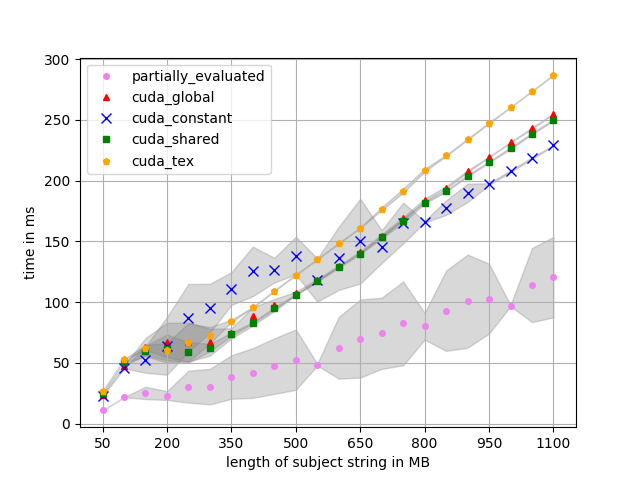

In [2]:
from functools import reduce
from IPython.display import Image
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import math
import matplotlib.ticker as plticker
import json



def red(test_list):
    res = [0 for i in range(0,len(test_list[0]))];#12
    for i in test_list: #for each pair
        for j in range(0,len(res)):#7
            res[j]+=int(i[j])
    return list(map(lambda x : x / len(test_list) ,res))

def deviation_float(test_list,avg):
    dev = [[0 for i in range(len(test_list[0][0]))] for j in range(len(test_list))] #for each size
    for i in range(len(test_list)): #for each size
        for j in range(len(test_list[i])): #for each clock
            for e in range(len(test_list[i][j])):
                val = float(test_list[i][j][e])
#                 if(val > 1 and val < 2):
#                     val = val * 1000
                dev[i][e] = dev[i][e] + (((val - avg[e][i])**2) / (len(test_list[i])-1)) #std dev
    res = [[] for i in range(len(avg))]
    for i in range(len(avg)): #for each algorithm
        for e in dev: #for each size
             res[i].append(math.sqrt(e[i]))
    return res


def build_set_float(test_list):
    size = len(test_list[0][0])
    def red_(l):
        res = [0 for i in range(0,len(l[0]))];#12
        for i in l: #for each pair
            for j in range(0,len(res)):#7
                value = float(i[j])
                res[j]+=value
        return list(map(lambda x : x / len(l) ,res))
    
    res = [[] for i in range(0,size)]
    for i in test_list: #for each text size
        data = red_(i) #average for specific run
        for j in range(0,size):
            res[j].append(data[j])
    return res

# read captured data
data = []
with open(runner.output_file,'rb') as dump:
    source = dump.read()
    data = json.loads(source)
    
    
empirical_avg = build_set_float(data)

dev = deviation_float(data,empirical_avg)

mns_devplus = [[empirical_avg[j][i]+dev[j][i] for i in range(len(empirical_avg[j]))] for j in range(len(empirical_avg))]
mns_devminus = [[empirical_avg[j][i]-dev[j][i] for i in range(len(empirical_avg[j]))] for j in range(len(empirical_avg))]

# args = [100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500, 2700, 2900, 3100, 3300, 3500, 3700, 3900, 4100, 4300, 4500, 4700, 4900, 5100, 5300, 5500, 5700, 5900, 6100, 6300, 6500, 6700, 6900, 7100, 7300]

args = sizes

yticks = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]
yticks_ = [i for i in range(0,501,50)]

points = len(data)

# plt.yticks(yticks_)
# plt.xticks((args[2::5]) + [7300])
plt.xticks(args[::3])
plt.grid()

plt.fill_between(args[:points],mns_devplus[0],mns_devminus[0],interpolate=False,color='gray', alpha=0.3)
plt.fill_between(args[:points],mns_devplus[1],mns_devminus[1],interpolate=False,color='gray', alpha=0.3)
plt.fill_between(args[:points],mns_devplus[2],mns_devminus[2],interpolate=False,color='gray', alpha=0.3)
plt.fill_between(args[:points],mns_devplus[3],mns_devminus[3],interpolate=False,color='gray', alpha=0.3)
plt.fill_between(args[:points],mns_devplus[4],mns_devminus[4],interpolate=False,color='gray', alpha=0.3)

plt.plot(args[:points],empirical_avg[0],'o',label='partially_evaluated',color='violet',markersize=4)
plt.plot(args[:points],empirical_avg[1],'^',label='cuda_global',color='red',markersize=5)
plt.plot(args[:points],empirical_avg[2],'x',label='cuda_constant',color='blue',markersize=7)
plt.plot(args[:points],empirical_avg[3],'s',label='cuda_shared',color='green',markersize=5)
plt.plot(args[:points],empirical_avg[4],'p',label='cuda_tex',color='orange',markersize=5)


plt.ylabel('time in ms')
plt.xlabel('length of subject string in MB')

plt.legend()
plt.show()

# uncomment to save figure
plt.savefig('data/results_multipattern_T4_dumped_final_poster1writeO4_ldgn2o.pdf')